Bureau of Labor Statistics API with Python
======

## Unemployment rates by race/origin 

------

*September 3, 2017*<br>
*@bd_econ*

BLS API documentation is [here](https://www.bls.gov/developers/)

This example collects data on the unemployment rate for Whie, Black, and Hispanic populations in the US and plots the results.

In [5]:
%matplotlib inline
import pandas as pd
import requests
import json

url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# API key in config.py which contains: bls_key = 'key'
import config
key = '?registrationkey={}'.format(config.bls_key)

## Parameters/ Date handling

The BLS API limits how many years of data can be returned in a request. The small while loop below splits a date range into chunks that the BLS API will accept.

In [13]:
# Series stored as a dictionary
series = {'PRS85006092': 'PRS85006092'}

# Start year and end year
date_r = (2000, 2018)

# Handle dates
dates = [(str(date_r[0]), str(date_r[1]))]
while int(dates[-1][1]) - int(dates[-1][0]) > 10:
    dates = [(str(date_r[0]), str(date_r[0]+9))]
    d1 = int(dates[-1][0])
    while int(dates[-1][1]) < date_r[1]:
        d1 = d1 + 10
        d2 = min([date_r[1], d1+9])
        dates.append((str(d1),(d2))) 

## Get the data

In [14]:
df = pd.DataFrame()

for start, end in dates:
    # Submit the list of series as data
    data = json.dumps({
        "seriesid": list(series.keys()),
        "startyear": start, "endyear": end})

    # Post request for the data
    p = requests.post(
        f'{url}{key}', 
        headers={'Content-type': 'application/json'}, 
        data=data).json()
    for s in p['Results']['series']:
        col = series[s['seriesID']]
        for r in s['data']:
            date = pd.to_datetime(
                (f"{r['year']}Q{r['period'][-1]}"
                 if r['period'][0] == 'Q'
                 else f"{r['periodName']} {r['year']}"))
            df.at[date, col] = float(r['value'])
df = df.sort_index()
# Output results
print('Post Request Status: {}'.format(p['status']))
df.tail(13)

Post Request Status: REQUEST_SUCCEEDED


,PRS85006092
2015-01-01,3.0
2015-04-01,1.3
2015-07-01,1.2
2015-10-01,-2.7
2016-01-01,-1.1
2016-04-01,1.0
2016-07-01,2.4
2016-10-01,1.2
2017-01-01,0.2
2017-04-01,1.7


## Plot the results

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

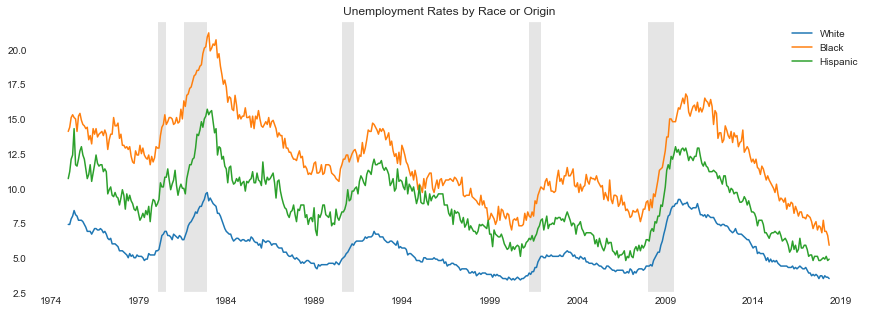

In [13]:
df.dropna().plot(title='Unemployment Rates by Race or Origin', figsize=(15, 5))

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().loc[2:].iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, 
                linewidth=0, color='gray', alpha=0.2)  